In [2]:
! pip install mordred
! pip install pubchempy
! pip install -U scikit-learn

DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\absl_py-1.4.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\astunparse-1.6.3-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\cachetools-5.3.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\flatbuffers-23.5.26-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package ins

DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\absl_py-1.4.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\astunparse-1.6.3-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\cachetools-5.3.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\flatbuffers-23.5.26-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package ins

DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\absl_py-1.4.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\astunparse-1.6.3-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\cachetools-5.3.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\flatbuffers-23.5.26-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package ins

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from mordred import Calculator, descriptors
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("data_compound.csv")
df = df.drop_duplicates(ignore_index=True)
df

,sid,cid,smiles,activity,type,value (nM)
0,316936203,118159182,C[C@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CC...,Active,IC50,0.0066
1,316936247,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,0.0083
2,316936221,118159272,CC(C)NC1=NC2=C(CN(CC2)C(=O)C)N=C1N3CCC(CC3)C(C...,Active,IC50,0.0085
3,316936228,118159276,CC(C)NC1=NC2=C(CN(CC2)C)N=C1N3CCC(CC3)C(=O)C4=...,Active,IC50,0.0088
4,316936201,118159362,CN(C)C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CCC(...,Active,IC50,0.0091
...,...,...,...,...,...,...
1168,374323466,118159345,CC1C2=C(CCN1S(=O)(=O)C)N=C(C(=N2)N3CCC(CC3)OC4...,Unspecified,IC50,98000.0000
1169,336857408,9879918,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC3=CC=CC=C3C=C2,Unspecified,IC50,100000.0000
1170,336857410,9966680,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC3=CC=CC=C32,Unspecified,IC50,100000.0000
1171,336857473,4526747,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC=C2,Unspecified,IC50,100000.0000


In [5]:
df['activity'].value_counts()

Active         790
Unspecified    225
Inactive       158
Name: activity, dtype: int64

In [8]:
df_hist = df[['smiles','activity', 'type', 'value (nM)']]
df_hist

,smiles,activity,type,value (nM)
0,C[C@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CC...,Active,IC50,0.0066
1,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,0.0083
2,CC(C)NC1=NC2=C(CN(CC2)C(=O)C)N=C1N3CCC(CC3)C(C...,Active,IC50,0.0085
3,CC(C)NC1=NC2=C(CN(CC2)C)N=C1N3CCC(CC3)C(=O)C4=...,Active,IC50,0.0088
4,CN(C)C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CCC(...,Active,IC50,0.0091
...,...,...,...,...
1168,CC1C2=C(CCN1S(=O)(=O)C)N=C(C(=N2)N3CCC(CC3)OC4...,Unspecified,IC50,98000.0000
1169,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC3=CC=CC=C3C=C2,Unspecified,IC50,100000.0000
1170,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC3=CC=CC=C32,Unspecified,IC50,100000.0000
1171,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC=C2,Unspecified,IC50,100000.0000


In [117]:
IC50_only = df_hist[df_hist['type']=='IC50']
IC50_only['pIC50'] = 9 - np.log10(IC50_only['value (nM)'])
IC50_only

C:\Users\supak\AppData\Local\Temp\ipykernel_6204\3773520078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IC50_only['pIC50'] = 9 - np.log10(IC50_only['value (nM)'])


,smiles,activity,type,value (nM),pIC50
0,C[C@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CC...,Active,IC50,0.0066,11.180456
1,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,0.0083,11.080922
2,CC(C)NC1=NC2=C(CN(CC2)C(=O)C)N=C1N3CCC(CC3)C(C...,Active,IC50,0.0085,11.070581
3,CC(C)NC1=NC2=C(CN(CC2)C)N=C1N3CCC(CC3)C(=O)C4=...,Active,IC50,0.0088,11.055517
4,CN(C)C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CCC(...,Active,IC50,0.0091,11.040959
...,...,...,...,...,...
1167,CC(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCN(CC3)CC4=C(C=...,Unspecified,IC50,97800.0000,4.009661
1168,CC1C2=C(CCN1S(=O)(=O)C)N=C(C(=N2)N3CCC(CC3)OC4...,Unspecified,IC50,98000.0000,4.008774
1169,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC3=CC=CC=C3C=C2,Unspecified,IC50,100000.0000,4.000000
1170,C1CN(C(=S)N1)C(=S)NC(=O)C2=CC=CC3=CC=CC=C32,Unspecified,IC50,100000.0000,4.000000


<Figure size 2000x2000 with 0 Axes>

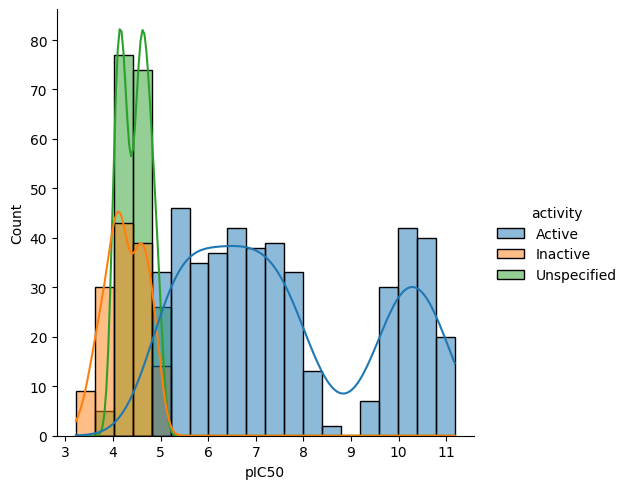

In [119]:
plt.figure(figsize=(20, 20))

sns.displot(IC50_only, bins=20, x='pIC50', hue='activity', kde=True)
plt.show()

In [120]:
def canonical_smiles(smiles):
    mol_smiles = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mol_smiles]

    return smiles

In [121]:
CANNO_SMILES = canonical_smiles(df.smiles)
len(CANNO_SMILES)

1173

In [122]:
df['smiles'] = CANNO_SMILES
df

,sid,cid,smiles,activity,type,value (nM)
0,316936203,118159182,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,IC50,0.0066
1,316936247,118159176,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,IC50,0.0083
2,316936221,118159272,CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F...,Active,IC50,0.0085
3,316936228,118159276,CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)C...,Active,IC50,0.0088
4,316936201,118159362,CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc...,Active,IC50,0.0091
...,...,...,...,...,...,...
1168,374323466,118159345,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)C(C)N(...,Unspecified,IC50,98000.0000
1169,336857408,9879918,O=C(NC(=S)N1CCNC1=S)c1ccc2ccccc2c1,Unspecified,IC50,100000.0000
1170,336857410,9966680,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,IC50,100000.0000
1171,336857473,4526747,O=C(NC(=S)N1CCNC1=S)c1ccccc1,Unspecified,IC50,100000.0000


In [123]:
smiles_list = list(df["smiles"])
smiles_list

['CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F)CC3)nc2C1',
 'CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)CN(C)CC2',
 'CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'CN1CCc2nc(NC3CC3)c(N3CCC(C(F)c4ccc(F)cc4F)CC3)nc2C1',
 'CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(=O)c4cc(Cl)ccc4F)CC3)nc2C1',
 'CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CCN(C(=O)N(C)C)C2',
 'CC1Cc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2CN1S(C)(=O)=O',
 'CC(C)Nc1nc2c(nc1N1CCC([C@H](F)c3ccc(F)cc3F)CC1)CCN(C=O)C2',
 'CC(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F)CC3)nc2C1',
 'COc1ccc(OC2CCN(c3nc4c(nc3NC3CCC3)CCN(C(C)=O)C4)CC2)c(F)c1',
 'CC(=O)N1CCc2nc(N3CCC(C(F)c4ccc(F)cc4F)CC3)c(NC(C)C)nc2C1',
 'CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)CCN(C)C2',
 'CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN(C(=O)N(C)C)CC2C',
 'CC(=O)N1CCc

**RDkit Descriptor**

In [124]:
smiles2 = [Chem.MolFromSmiles(i) for i in smiles_list]
mols2 = [m for m in smiles2]
len(mols2)

1173

In [125]:
alldesc = [Descriptors.CalcMolDescriptors(m) for m in mols2]
rdkit_gpr6 = pd.DataFrame(alldesc)
rdkit_gpr6

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.972261,13.972261,0.015965,-2.565677,0.544559,511.520,482.288,511.220653,196,0,...,0,0,0,0,0,0,0,0,0,0
1,13.972261,13.972261,0.015965,-2.565677,0.544559,511.520,482.288,511.220653,196,0,...,0,0,0,0,0,0,0,0,0,0
2,15.079211,15.079211,0.010379,-1.486341,0.715021,461.532,431.292,461.240245,178,0,...,0,0,0,0,0,0,0,0,0,0
3,14.162533,14.162533,0.087707,-0.509331,0.696577,445.970,416.738,445.204466,166,0,...,0,0,0,0,0,0,0,0,0,0
4,13.954396,13.954396,0.010776,-2.556825,0.617440,496.509,468.285,496.220987,190,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,13.985168,13.985168,0.046553,-3.362224,0.656323,495.596,464.348,495.211567,186,0,...,0,1,0,0,0,0,0,0,0,0
1169,12.273204,12.273204,0.221803,-0.221803,0.788690,315.423,302.319,315.050004,106,0,...,0,0,0,0,0,0,0,0,0,0
1170,12.443502,12.443502,0.216204,-0.216204,0.788690,315.423,302.319,315.050004,106,0,...,0,0,0,0,0,0,0,0,0,0
1171,11.829516,11.829516,0.217315,-0.217315,0.738475,265.363,254.275,265.034354,88,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
#df_gpr6_compound = df.join(df_descrs)
#df_gpr6_compound

In [127]:
df_smiles = df[['smiles', 'activity']]
df_merged_smiles_rdkit = df_smiles.join(rdkit_gpr6)
df_merged_smiles_rdkit

,smiles,activity,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,13.972261,13.972261,0.015965,-2.565677,0.544559,511.520,482.288,511.220653,...,0,0,0,0,0,0,0,0,0,0
1,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,13.972261,13.972261,0.015965,-2.565677,0.544559,511.520,482.288,511.220653,...,0,0,0,0,0,0,0,0,0,0
2,CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F...,Active,15.079211,15.079211,0.010379,-1.486341,0.715021,461.532,431.292,461.240245,...,0,0,0,0,0,0,0,0,0,0
3,CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)C...,Active,14.162533,14.162533,0.087707,-0.509331,0.696577,445.970,416.738,445.204466,...,0,0,0,0,0,0,0,0,0,0
4,CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc...,Active,13.954396,13.954396,0.010776,-2.556825,0.617440,496.509,468.285,496.220987,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)C(C)N(...,Unspecified,13.985168,13.985168,0.046553,-3.362224,0.656323,495.596,464.348,495.211567,...,0,1,0,0,0,0,0,0,0,0
1169,O=C(NC(=S)N1CCNC1=S)c1ccc2ccccc2c1,Unspecified,12.273204,12.273204,0.221803,-0.221803,0.788690,315.423,302.319,315.050004,...,0,0,0,0,0,0,0,0,0,0
1170,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,12.443502,12.443502,0.216204,-0.216204,0.788690,315.423,302.319,315.050004,...,0,0,0,0,0,0,0,0,0,0
1171,O=C(NC(=S)N1CCNC1=S)c1ccccc1,Unspecified,11.829516,11.829516,0.217315,-0.217315,0.738475,265.363,254.275,265.034354,...,0,0,0,0,0,0,0,0,0,0


In [128]:
#df_merged_smiles_rdkit.to_csv("rdkit_descriptors_gpr6.csv", index=False)

**Mordred Descriptors**

In [129]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=True)
    smiles3 = [Chem.MolFromSmiles(i) for i in data]
    
    df_mordred = calc.pandas(smiles3)
    return df_mordred

In [130]:
mordred_gpr6 = All_Mordred_descriptors(smiles_list)
mordred_gpr6.shape


(1173, 1613)

In [131]:
mordred_gpr6

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,27.990863,20.208094,0,0,46.356073,2.463468,4.926935,46.356073,1.287669,4.505313,...,10.488186,72.610895,511.220653,7.864933,4404,59,188.0,220.0,12.444444,7.916667
1,27.990863,20.208094,0,0,46.356073,2.463468,4.926935,46.356073,1.287669,4.505313,...,10.488186,72.610895,511.220653,7.864933,4404,59,188.0,220.0,12.444444,7.916667
2,25.938492,19.114455,0,0,41.715306,2.464737,4.929475,41.715306,1.2641,4.426747,...,10.479904,69.390362,461.240245,7.321274,3374,56,176.0,208.0,11.694444,7.111111
3,24.455329,18.151364,0,1,39.965051,2.458558,4.917115,39.965051,1.289195,4.367884,...,10.421954,67.098280,445.204466,7.420074,2814,52,166.0,196.0,10.583333,6.666667
4,27.393146,19.733756,0,0,44.686795,2.462679,4.925359,44.686795,1.276766,4.479689,...,10.470136,71.509172,496.220987,7.876524,4064,57,184.0,215.0,12.194444,7.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,26.882406,19.827162,0,0,42.133369,2.501032,5.002063,42.133369,1.239217,4.458711,...,10.573238,70.701159,495.211567,7.618639,3642,58,184.0,217.0,12.645833,7.166667
1169,16.429865,13.664452,0,0,27.401028,2.384287,4.759565,27.401028,1.304811,3.980697,...,9.904837,68.408889,315.050004,9.266177,982,31,110.0,129.0,6.527778,4.611111
1170,16.389425,13.970163,0,0,27.414752,2.41071,4.815058,27.414752,1.305464,3.980899,...,9.946882,68.480833,315.050004,9.266177,938,32,110.0,130.0,6.527778,4.638889
1171,12.934771,11.784329,0,0,21.715145,2.336064,4.611816,21.715145,1.277361,3.748934,...,9.490015,62.801832,265.034354,9.465513,548,22,84.0,96.0,5.805556,3.833333


In [132]:
df_merged_smiles_mordred = df_smiles.join(mordred_gpr6)
df_merged_smiles_mordred

,smiles,activity,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,27.990863,20.208094,0,0,46.356073,2.463468,4.926935,46.356073,...,10.488186,72.610895,511.220653,7.864933,4404,59,188.0,220.0,12.444444,7.916667
1,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,27.990863,20.208094,0,0,46.356073,2.463468,4.926935,46.356073,...,10.488186,72.610895,511.220653,7.864933,4404,59,188.0,220.0,12.444444,7.916667
2,CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F...,Active,25.938492,19.114455,0,0,41.715306,2.464737,4.929475,41.715306,...,10.479904,69.390362,461.240245,7.321274,3374,56,176.0,208.0,11.694444,7.111111
3,CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)C...,Active,24.455329,18.151364,0,1,39.965051,2.458558,4.917115,39.965051,...,10.421954,67.098280,445.204466,7.420074,2814,52,166.0,196.0,10.583333,6.666667
4,CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc...,Active,27.393146,19.733756,0,0,44.686795,2.462679,4.925359,44.686795,...,10.470136,71.509172,496.220987,7.876524,4064,57,184.0,215.0,12.194444,7.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)C(C)N(...,Unspecified,26.882406,19.827162,0,0,42.133369,2.501032,5.002063,42.133369,...,10.573238,70.701159,495.211567,7.618639,3642,58,184.0,217.0,12.645833,7.166667
1169,O=C(NC(=S)N1CCNC1=S)c1ccc2ccccc2c1,Unspecified,16.429865,13.664452,0,0,27.401028,2.384287,4.759565,27.401028,...,9.904837,68.408889,315.050004,9.266177,982,31,110.0,129.0,6.527778,4.611111
1170,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,16.389425,13.970163,0,0,27.414752,2.41071,4.815058,27.414752,...,9.946882,68.480833,315.050004,9.266177,938,32,110.0,130.0,6.527778,4.638889
1171,O=C(NC(=S)N1CCNC1=S)c1ccccc1,Unspecified,12.934771,11.784329,0,0,21.715145,2.336064,4.611816,21.715145,...,9.490015,62.801832,265.034354,9.465513,548,22,84.0,96.0,5.805556,3.833333


In [133]:
#df_merged_smiles_mordred.to_csv("mordred_descriptors_gpr6.csv", index=False)

**Data Preprocessing**

In [134]:
rdkit_gpr6.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.0,...,1173.000000,1173.000000,1173.000000,1173.0,1173.0,1173.000000,1173.0,1173.000000,1173.000000,1173.000000
mean,13.666667,13.666667,0.099135,-2.068846,0.585626,481.340679,455.551190,480.932042,180.264280,0.0,...,0.004263,0.050298,0.023018,0.0,0.0,0.006820,0.0,0.014493,0.015345,0.060529
std,1.275448,1.275448,0.131084,1.902632,0.124493,69.865372,66.820526,69.799860,28.046312,0.0,...,0.065177,0.218653,0.150024,0.0,0.0,0.082337,0.0,0.119561,0.129727,0.238565
min,4.796402,4.796402,0.000000,-5.083333,0.243006,253.308000,246.252000,252.997968,82.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
25%,13.884794,13.884794,0.021125,-3.580033,0.493201,449.477000,423.758000,449.166331,170.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
50%,13.966283,13.966283,0.048270,-0.749337,0.594579,481.494000,453.727000,481.195917,182.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
75%,14.056653,14.056653,0.106209,-0.678636,0.688873,517.508000,491.300000,517.177074,196.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
max,15.248740,15.248740,0.791107,0.716349,0.864780,656.641000,629.821000,656.248264,248.000000,0.0,...,1.000000,1.000000,1.000000,0.0,0.0,1.000000,0.0,1.000000,2.000000,1.000000


In [135]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

In [136]:
x = scaler.fit_transform(rdkit_gpr6)
x

array([[ 0.23969931,  0.23969931, -0.63474726, ..., -0.12126781,
        -0.11833913, -0.25382733],
       [ 0.23969931,  0.23969931, -0.63474726, ..., -0.12126781,
        -0.11833913, -0.25382733],
       [ 1.10796054,  1.10796054, -0.67738309, ..., -0.12126781,
        -0.11833913, -0.25382733],
       ...,
       [-0.95941724, -0.95941724,  0.89345805, ..., -0.12126781,
        -0.11833913, -0.25382733],
       [-1.44101037, -1.44101037,  0.90193798, ..., -0.12126781,
        -0.11833913, -0.25382733],
       [ 0.1581069 ,  0.1581069 , -0.02715772, ..., -0.12126781,
        -0.11833913, -0.25382733]])

In [137]:
rdkit_standardized = pd.DataFrame(x, columns=rdkit_gpr6.columns)
rdkit_standardized

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.239699,0.239699,-0.634747,-0.261240,-0.330016,0.432148,0.400299,0.434120,0.561301,0.0,...,-0.065428,-0.230135,-0.153493,0.0,0.0,-0.082867,0.0,-0.121268,-0.118339,-0.253827
1,0.239699,0.239699,-0.634747,-0.261240,-0.330016,0.432148,0.400299,0.434120,0.561301,0.0,...,-0.065428,-0.230135,-0.153493,0.0,0.0,-0.082867,0.0,-0.121268,-0.118339,-0.253827
2,1.107961,1.107961,-0.677383,0.306288,1.039827,-0.283647,-0.363205,-0.282238,-0.080768,0.0,...,-0.065428,-0.230135,-0.153493,0.0,0.0,-0.082867,0.0,-0.121268,-0.118339,-0.253827
3,0.388943,0.388943,-0.087224,0.820012,0.891608,-0.506485,-0.581105,-0.512076,-0.508814,0.0,...,-0.065428,-0.230135,-0.153493,0.0,0.0,-0.082867,0.0,-0.121268,-0.118339,-0.253827
4,0.225687,0.225687,-0.674355,-0.256585,0.255656,0.217200,0.190649,0.219133,0.347278,0.0,...,-0.065428,-0.230135,-0.153493,0.0,0.0,-0.082867,0.0,-0.121268,-0.118339,3.939686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,0.249823,0.249823,-0.401307,-0.680073,0.568126,0.204127,0.131704,0.204665,0.204596,0.0,...,-0.065428,4.345268,-0.153493,0.0,0.0,-0.082867,0.0,-0.121268,-0.118339,-0.253827
1169,-1.092994,-1.092994,0.936189,0.971198,1.631833,-2.375833,-2.294169,-2.377552,-2.649045,0.0,...,-0.065428,-0.230135,-0.153493,0.0,0.0,-0.082867,0.0,-0.121268,-0.118339,-0.253827
1170,-0.959417,-0.959417,0.893458,0.974142,1.631833,-2.375833,-2.294169,-2.377552,-2.649045,0.0,...,-0.065428,-0.230135,-0.153493,0.0,0.0,-0.082867,0.0,-0.121268,-0.118339,-0.253827
1171,-1.441010,-1.441010,0.901938,0.973557,1.228299,-3.092659,-3.013476,-3.094416,-3.291115,0.0,...,-0.065428,-0.230135,-0.153493,0.0,0.0,-0.082867,0.0,-0.121268,-0.118339,-0.253827


In [138]:
rdkit_standardized.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,1.173000e+03,1.173000e+03,1.173000e+03,1.173000e+03,1.173000e+03,1.173000e+03,1.173000e+03,1.173000e+03,1.173000e+03,1173.0,...,1.173000e+03,1.173000e+03,1.173000e+03,1173.0,1173.0,1173.000000,1173.0,1.173000e+03,1.173000e+03,1173.000000
mean,-2.907592e-16,-2.907592e-16,3.028741e-17,3.271041e-16,9.086224e-16,8.541051e-16,-1.005542e-15,3.937364e-16,-4.179663e-16,0.0,...,1.211497e-17,3.634490e-17,-1.817245e-17,0.0,0.0,0.000000,0.0,6.057483e-18,-6.057483e-18,0.000000
std,1.000427e+00,1.000427e+00,1.000427e+00,1.000427e+00,1.000427e+00,1.000427e+00,1.000427e+00,1.000427e+00,1.000427e+00,0.0,...,1.000427e+00,1.000427e+00,1.000427e+00,0.0,0.0,1.000427,0.0,1.000427e+00,1.000427e+00,1.000427
min,-6.957591e+00,-6.957591e+00,-7.565948e-01,-1.585053e+00,-2.753305e+00,-3.265279e+00,-3.133595e+00,-3.266931e+00,-3.505138e+00,0.0,...,-6.542799e-02,-2.301354e-01,-1.534934e-01,0.0,0.0,-0.082867,0.0,-1.212678e-01,-1.183391e-01,-0.253827
25%,1.710927e-01,1.710927e-01,-5.953736e-01,-7.945999e-01,-7.427305e-01,-4.562671e-01,-4.760027e-01,-4.552912e-01,-3.661322e-01,0.0,...,-6.542799e-02,-2.301354e-01,-1.534934e-01,0.0,0.0,-0.082867,0.0,-1.212678e-01,-1.183391e-01,-0.253827
50%,2.350103e-01,2.350103e-01,-3.882029e-01,6.938138e-01,7.194764e-02,2.195451e-03,-2.731149e-02,3.782066e-03,6.191405e-02,0.0,...,-6.542799e-02,-2.301354e-01,-1.534934e-01,0.0,0.0,-0.082867,0.0,-1.212678e-01,-1.183391e-01,-0.253827
75%,3.058944e-01,3.058944e-01,5.398554e-02,7.309894e-01,8.296936e-01,5.178924e-01,5.352256e-01,5.194923e-01,5.613013e-01,0.0,...,-6.542799e-02,-2.301354e-01,-1.534934e-01,0.0,0.0,-0.082867,0.0,-1.212678e-01,-1.183391e-01,-0.253827
max,1.240935e+00,1.240935e+00,5.281086e+00,1.464489e+00,2.243287e+00,2.510186e+00,2.609141e+00,2.512770e+00,2.416168e+00,0.0,...,1.528398e+01,4.345268e+00,6.514940e+00,0.0,0.0,12.067518,0.0,8.246211e+00,1.530519e+01,3.939686


In [139]:
rdkit_standardized.to_csv("standardized_rdkit_gpr6.csv", index=False)

In [140]:
X = rdkit_standardized

**PCA**

In [141]:
from sklearn.decomposition import PCA

In [142]:
pca = PCA()
pca.fit(X)

PCA()

In [143]:
pca.explained_variance_ratio_

array([2.42869089e-01, 1.08880821e-01, 9.15121993e-02, 6.08222957e-02,
       4.20854390e-02, 3.61750075e-02, 3.22741224e-02, 2.71619319e-02,
       2.42647400e-02, 2.17919622e-02, 2.03848064e-02, 1.78549328e-02,
       1.59318780e-02, 1.37472984e-02, 1.26211993e-02, 1.20145839e-02,
       1.14519647e-02, 1.10719282e-02, 1.08654848e-02, 1.02163426e-02,
       9.77807626e-03, 8.44579050e-03, 7.97224595e-03, 7.44146820e-03,
       7.07984750e-03, 6.92098011e-03, 6.37874001e-03, 6.18861053e-03,
       6.03680859e-03, 5.96120362e-03, 5.87614562e-03, 5.73293279e-03,
       5.64558991e-03, 5.46889434e-03, 5.30151824e-03, 5.10510959e-03,
       4.75031117e-03, 4.53158792e-03, 4.31121697e-03, 3.82636306e-03,
       3.56248379e-03, 3.16473633e-03, 3.11315496e-03, 2.99382059e-03,
       2.73198808e-03, 2.54635581e-03, 2.29921661e-03, 2.21054831e-03,
       2.17193724e-03, 1.94056865e-03, 1.93422939e-03, 1.78187768e-03,
       1.73082345e-03, 1.62484086e-03, 1.52002134e-03, 1.39800750e-03,
      

Text(0, 0.5, 'Cumulative Explained Varience')

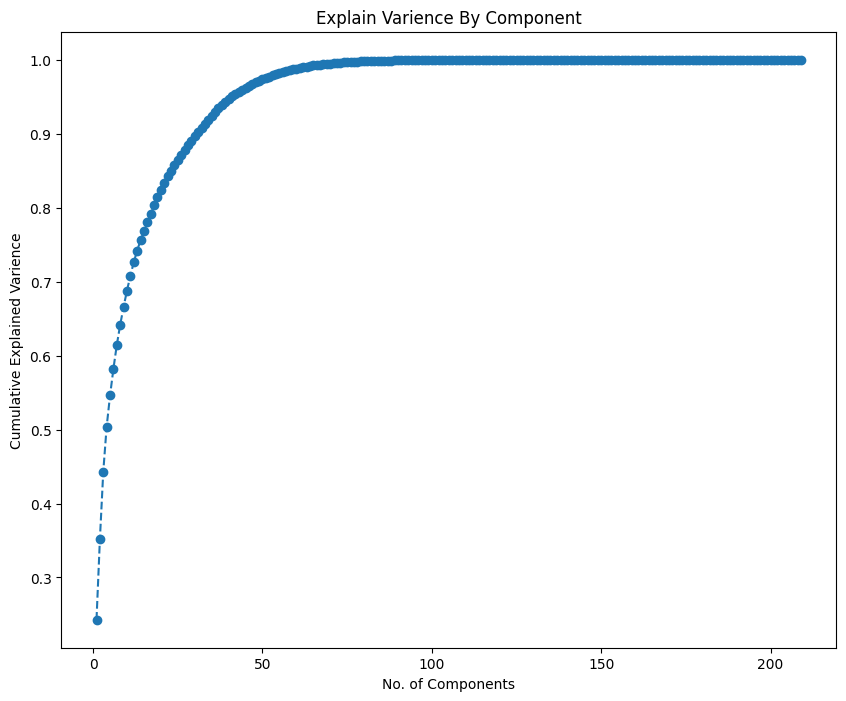

In [144]:
plt.figure(figsize = (10,8))
plt.plot(range(1,210), pca.explained_variance_ratio_.cumsum(), marker ='o', linestyle='--')
plt.title('Explain Varience By Component')
plt.xlabel('No. of Components')
plt.ylabel('Cumulative Explained Varience')

**MiniBatch KMeans**

In [145]:
from sklearn.cluster import MiniBatchKMeans

Optimize n cluster without PCA

c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The

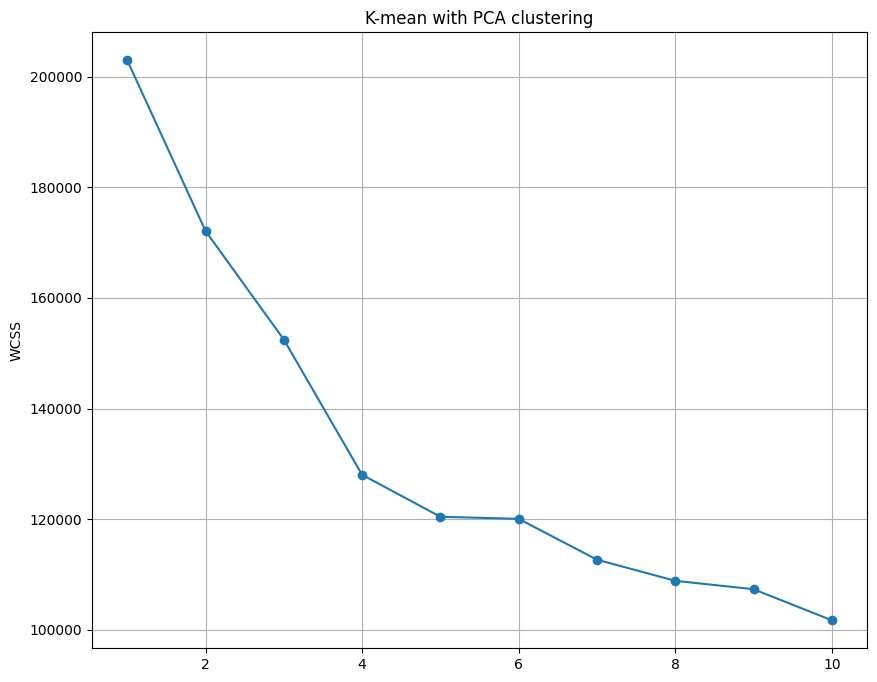

In [146]:
wcss = []
for i in range(1,11):
    mbk_pca = MiniBatchKMeans(n_clusters=i)
    mbk_pca.fit(X) #X represent entire datasets with all PCA component
    wcss.append(mbk_pca.inertia_)

plt.figure(figsize = (10,8))
plt.plot(range(1,11), wcss, 'o-')
plt.ylabel('WCSS')
plt.grid(True)
plt.title('K-mean with PCA clustering')
plt.show()

Silhouette Method

In [147]:
#import sklearn.cluster as cluster
#import sklearn.metrics as metrics
#from sklearn.metrics import silhouette_score


In [148]:
#silhouette_score(X_pca, mbk_pca.labels_)

In [149]:
#labels = [MiniBatchKMeans(n_clusters=i).fit(X_pca) for i in range(1,10)]
#silhouette_scores = [silhouette_score(X_pca, model.labels_) for model in labels[1:]]
#silhouette_scores

**Clustering K-Means Using PCA**

In [150]:
pca = PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

In [151]:
pca.explained_variance_ratio_

array([0.24286909, 0.10888082, 0.0915122 ])

In [152]:
X_pca = pca.transform(X)
X_pca.shape

(1173, 3)

Kmeans with PCA

c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_k

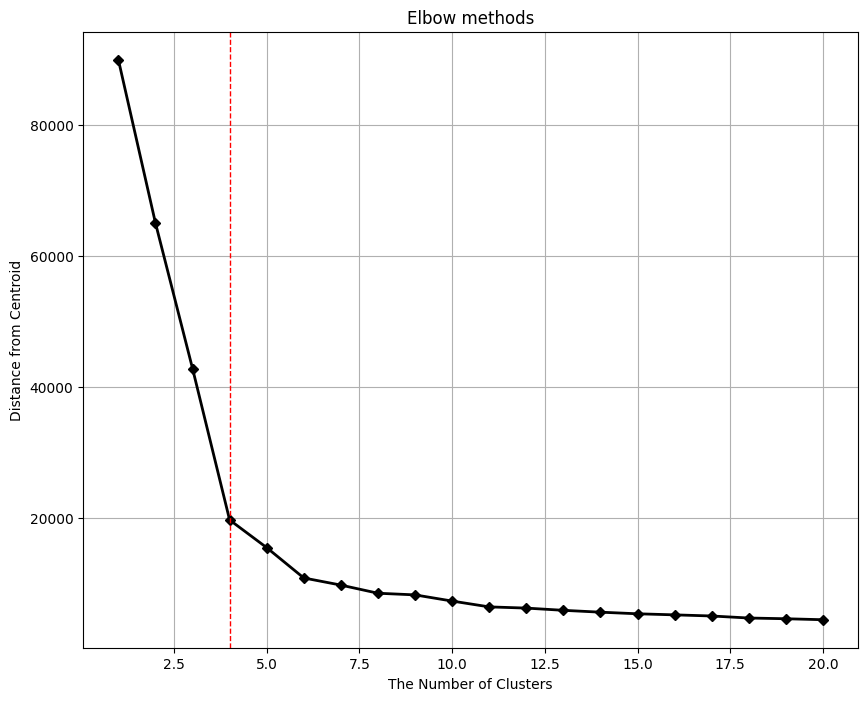

In [153]:
wcss = []
for i in range(1,21):
    mbk_pca = MiniBatchKMeans(n_clusters=i)
    mbk_pca.fit(X_pca)
    wcss.append(mbk_pca.inertia_)

plt.figure(figsize = (10,8))
plt.plot(range(1,21), wcss, linewidth = 2, color = 'black', marker = 'D', markersize = '5')
plt.xlabel('The Number of Clusters')
plt.ylabel('Distance from Centroid')
plt.grid(True)
plt.title('Elbow methods')
plt.axvline(x = 4, linewidth = 1, color = 'red', linestyle = '--')
plt.show()

In [154]:
df_pca_mbk = pd.concat([df, pd.DataFrame(X_pca)], axis=1)
for i in range(1, 4):
    df_pca_mbk.rename(columns={df_pca_mbk.columns[-i]: f'PCA{4 - i}'}, inplace=True)


for k in range (1,11):
    mbk_pca = MiniBatchKMeans(n_clusters=k)
    mbk_pca.fit(X_pca)
    df_pca_mbk[f'MBKMeans_{k}'] = mbk_pca.labels_
    
df_pca_mbk
    

c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_k

,sid,cid,smiles,activity,type,value (nM),PCA1,PCA2,PCA3,MBKMeans_1,MBKMeans_2,MBKMeans_3,MBKMeans_4,MBKMeans_5,MBKMeans_6,MBKMeans_7,MBKMeans_8,MBKMeans_9,MBKMeans_10
0,316936203,118159182,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,IC50,0.0066,-2.574391,-4.338503,-1.963956,0,0,0,0,0,1,5,0,4,8
1,316936247,118159176,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,IC50,0.0083,-2.574391,-4.338503,-1.963956,0,0,0,0,0,1,5,0,4,8
2,316936221,118159272,CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F...,Active,IC50,0.0085,1.133126,-2.772207,-4.137723,0,0,0,0,0,1,1,0,5,9
3,316936228,118159276,CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)C...,Active,IC50,0.0088,3.779020,-0.088238,-4.247029,0,0,0,0,4,4,1,6,2,9
4,316936201,118159362,CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc...,Active,IC50,0.0091,-1.774812,-3.877457,-2.668805,0,0,0,0,0,1,5,0,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,374323466,118159345,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)C(C)N(...,Unspecified,IC50,98000.0000,-1.249602,-3.389458,-3.920803,0,0,0,0,0,1,5,0,4,1
1169,336857408,9879918,O=C(NC(=S)N1CCNC1=S)c1ccc2ccccc2c1,Unspecified,IC50,100000.0000,16.840714,7.772342,0.603071,0,0,1,2,2,3,3,2,3,0
1170,336857410,9966680,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,IC50,100000.0000,16.825057,7.707287,0.529775,0,0,1,2,2,3,3,2,3,0
1171,336857473,4526747,O=C(NC(=S)N1CCNC1=S)c1ccccc1,Unspecified,IC50,100000.0000,20.365775,6.659534,-0.743235,0,0,1,2,2,3,3,2,3,0


Scatter Plot

In [155]:
! pip install plotly==5.15.0
import plotly.express as px
import seaborn as sns

DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\absl_py-1.4.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\astunparse-1.6.3-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\cachetools-5.3.1-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\supak\appdata\local\programs\python\python311\lib\site-packages\flatbuffers-23.5.26-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package ins

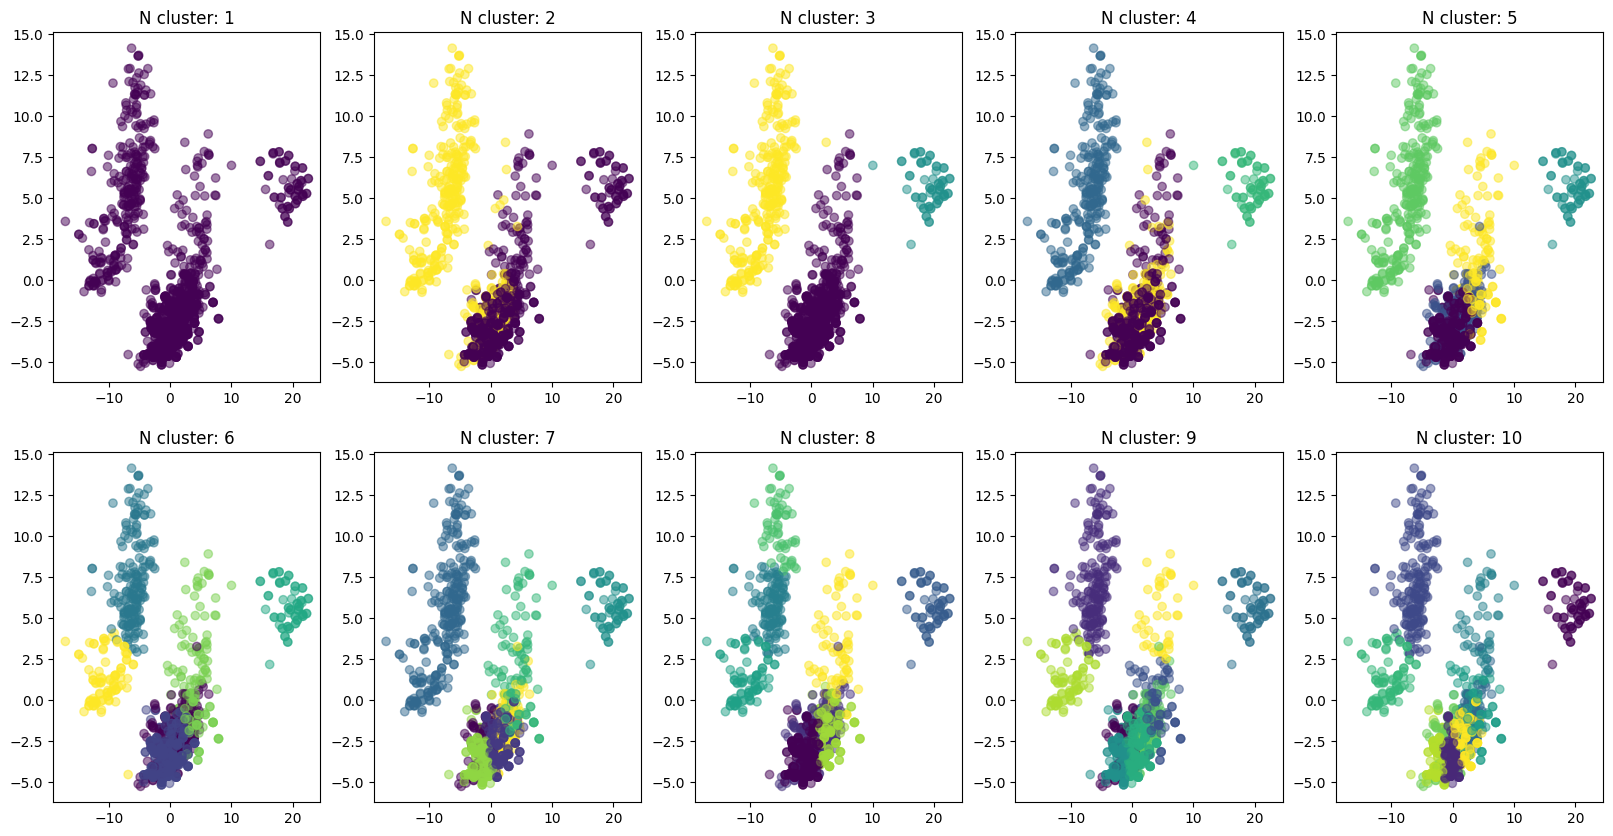

In [156]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=df_pca_mbk['PCA1'], y=df_pca_mbk['PCA2'], c=df_pca_mbk[f'MBKMeans_{i}'], alpha=0.5)
    ax.set_title(f'N cluster: {i}')


Customize PCA component

In [157]:
pca2 = PCA(n_components=2)
pca2.fit(X)

PCA(n_components=2)

In [158]:
X_pca2 = pca2.transform(X)
X_pca2.shape

(1173, 2)

In [159]:
df_pca_mbk2 = pd.concat([df, pd.DataFrame(X_pca2)], axis=1)
for i in range(1, 3):
    df_pca_mbk2.rename(columns={df_pca_mbk2.columns[-i]: f'PCA{3 - i}'}, inplace=True)



for k in range (1,11):
    mbk_pca2 = MiniBatchKMeans(n_clusters=k, random_state=42)
    mbk_pca2.fit(X_pca2)
    df_pca_mbk2[f'MBKMeans_{k}'] = mbk_pca2.labels_
    
df_pca_mbk2

c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\supak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_k

,sid,cid,smiles,activity,type,value (nM),PCA1,PCA2,MBKMeans_1,MBKMeans_2,MBKMeans_3,MBKMeans_4,MBKMeans_5,MBKMeans_6,MBKMeans_7,MBKMeans_8,MBKMeans_9,MBKMeans_10
0,316936203,118159182,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,IC50,0.0066,-2.574391,-4.338503,0,0,0,0,4,0,0,7,7,7
1,316936247,118159176,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,IC50,0.0083,-2.574391,-4.338503,0,0,0,0,4,0,0,7,7,7
2,316936221,118159272,CC(=O)N1CCc2nc(NC(C)C)c(N3CCC(C(F)c4ccc(F)cc4F...,Active,IC50,0.0085,1.133126,-2.772207,0,0,0,0,4,3,4,0,0,0
3,316936228,118159276,CC(C)Nc1nc2c(nc1N1CCC(C(=O)c3cc(Cl)ccc3F)CC1)C...,Active,IC50,0.0088,3.779020,-0.088237,0,0,0,3,0,3,5,6,6,6
4,316936201,118159362,CN(C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc...,Active,IC50,0.0091,-1.774812,-3.877457,0,0,0,0,4,0,0,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,374323466,118159345,CC(C)Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)C(C)N(...,Unspecified,IC50,98000.0000,-1.249602,-3.389457,0,0,0,0,4,0,0,7,7,9
1169,336857408,9879918,O=C(NC(=S)N1CCNC1=S)c1ccc2ccccc2c1,Unspecified,IC50,100000.0000,16.840714,7.772341,0,0,2,2,2,2,2,2,2,2
1170,336857410,9966680,O=C(NC(=S)N1CCNC1=S)c1cccc2ccccc12,Unspecified,IC50,100000.0000,16.825057,7.707287,0,0,2,2,2,2,2,2,2,2
1171,336857473,4526747,O=C(NC(=S)N1CCNC1=S)c1ccccc1,Unspecified,IC50,100000.0000,20.365775,6.659533,0,0,2,2,2,2,2,2,2,2


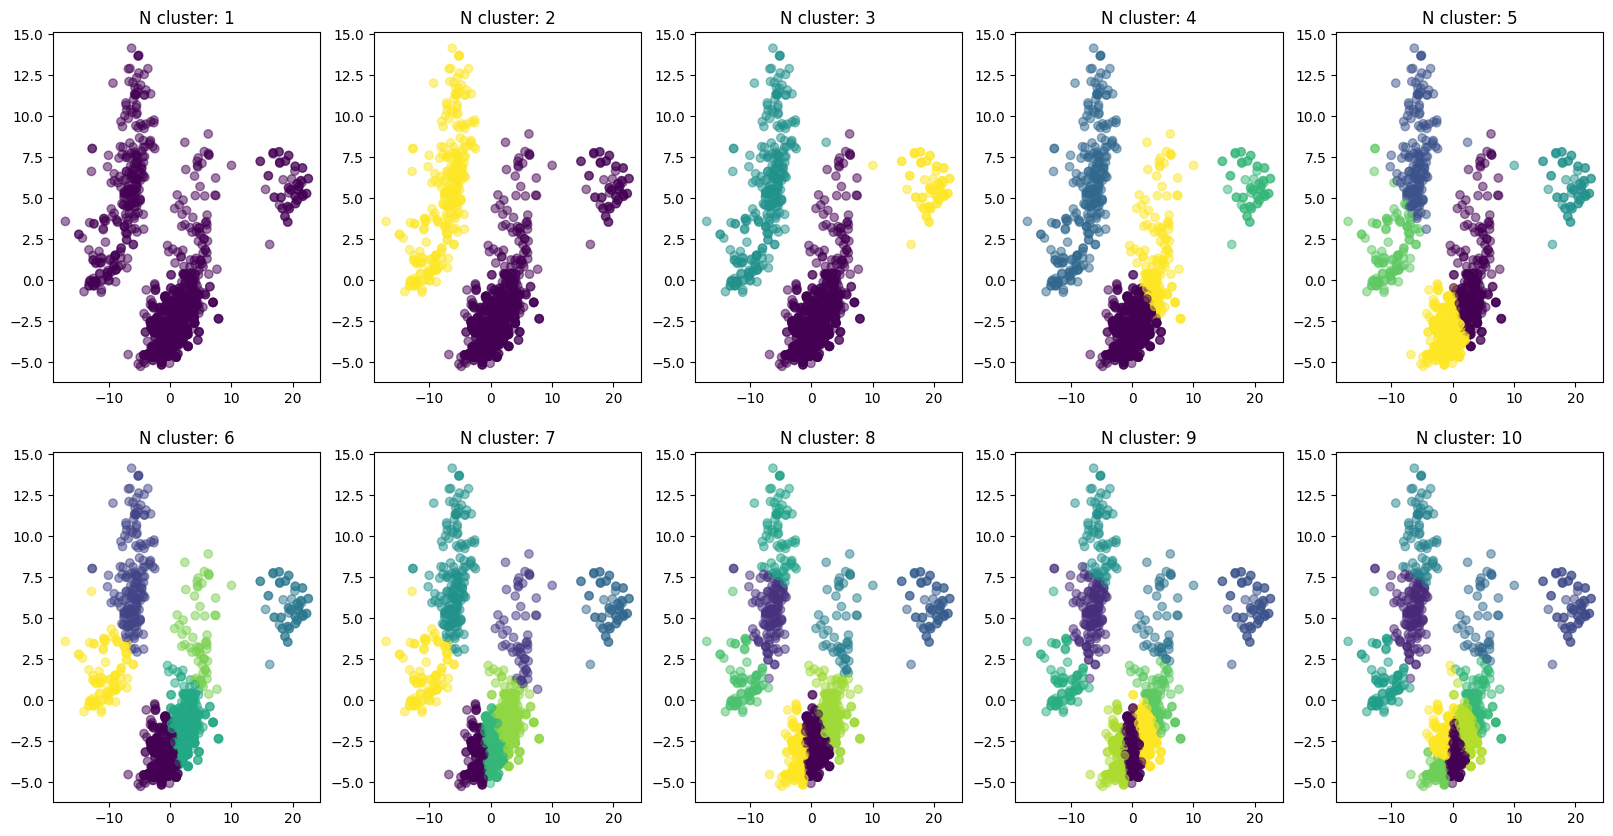

In [160]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=df_pca_mbk2['PCA1'], y=df_pca_mbk2['PCA2'], c=df_pca_mbk2[f'MBKMeans_{i}'], alpha=0.5)
    ax.set_title(f'N cluster: {i}')

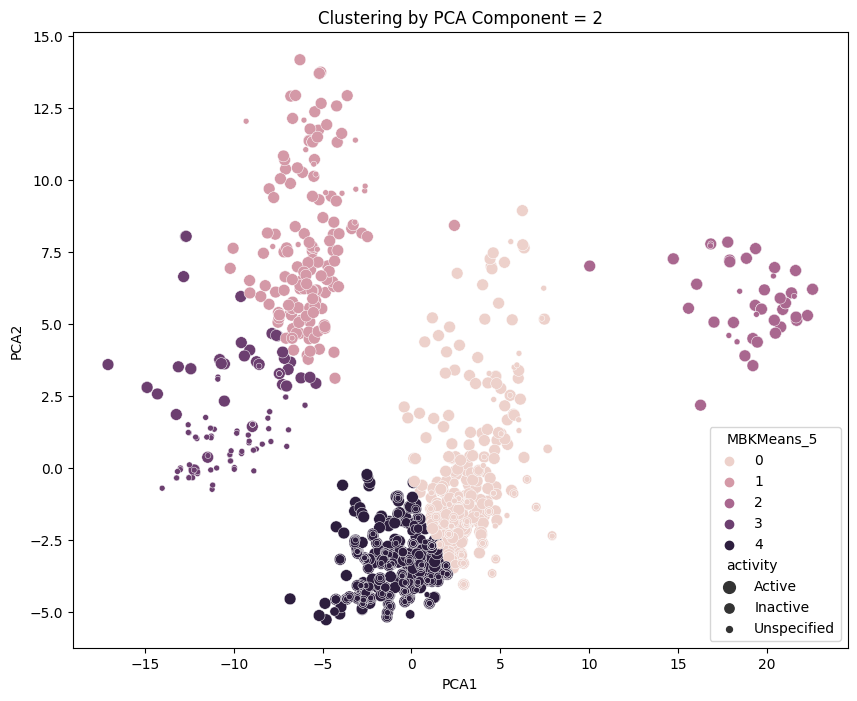

In [161]:
plt.figure(figsize = (10,8))
sns.scatterplot(df_pca_mbk2, x='PCA1', y='PCA2', hue='MBKMeans_5', size='activity')
plt.title('Clustering by PCA Component = 2')
plt.show()

In [162]:
#fig = px.scatter_3d(df_pca_mbk2, x='PCA1', y='PCA2', z='PCA3', color='MBKMeans_3')
#fig.show()

**Regression Methods**